# NLP Assignment 1 — Multilingual Word Embeddings



- Dataset preparation (English + French)
- Text preprocessing
- Embedding generation (One-hot, TF-IDF, Word2Vec, FastText)
- Multilingual alignment
- Visualization (PCA and t-SNE)
- Downstream classification task



In [1]:
# Install required libraries
!pip install numpy pandas scikit-learn gensim fasttext matplotlib nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.6 MB/s eta 0:00:00
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498212 sha256=0de549cd077951aeea9e8e74c1dfa60d332f4bfe942f065d7acfb4e87a643b18
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


## 1. Imports

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Dataset Preparation

## 2A. Real Dataset Loading (Tatoeba / OSCAR)

This section shows how to load **real multilingual datasets** using the Hugging Face `datasets` library.

You can choose either:

- Tatoeba (parallel sentences)
- OSCAR (large multilingual corpus)




In [3]:
# Install datasets library (run once)
!pip install datasets

### Option 1 — Load Tatoeba Parallel Corpus (English–French)

In [23]:
from datasets import load_dataset
import pandas as pd

# Load English–French parallel corpus
dataset = load_dataset("opus_books", "en-fr", split="train")



english_sentences = [item["translation"]["en"] for item in dataset]
french_sentences = [item["translation"]["fr"] for item in dataset]

df_en = pd.DataFrame({"text": english_sentences, "lang": "en"})
df_fr = pd.DataFrame({"text": french_sentences, "lang": "fr"})
df = pd.concat([df_en, df_fr]).reset_index(drop=True)

df.head()


,text,lang
0,The Wanderer,en
1,Alain-Fournier,en
2,First Part,en
3,I,en
4,THE BOARDER,en


### Option 2 — Load OSCAR Multilingual Corpus (Sampled)

In [ ]:
# Uncomment this block if you want to use OSCAR instead of Tatoeba

# dataset_en = load_dataset("oscar", "unshuffled_deduplicated_en", split="train[:1%]")
# dataset_fr = load_dataset("oscar", "unshuffled_deduplicated_fr", split="train[:1%]")

# english_sentences = [item["text"] for item in dataset_en][:5000]
# french_sentences = [item["text"] for item in dataset_fr][:5000]

# df_en = pd.DataFrame({"text": english_sentences, "lang": "en"})
# df_fr = pd.DataFrame({"text": french_sentences, "lang": "fr"})
# df = pd.concat([df_en, df_fr]).reset_index(drop=True)

# df.head()


### Text Preprocessing

In [24]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)
df["tokens"] = df["clean_text"].apply(simple_preprocess)

df


,text,lang,clean_text,tokens
0,The Wanderer,en,the wanderer,"[the, wanderer]"
1,Alain-Fournier,en,alainfournier,[alainfournier]
2,First Part,en,first part,"[first, part]"
3,I,en,i,[]
4,THE BOARDER,en,the boarder,"[the, boarder]"
...,...,...,...,...
254165,"Thérèse prit le verre, le vida à moitié et le ...",fr,thérèse prit le verre le vida à moitié et le t...,"[thérèse, prit, le, verre, le, vida, moitié, e..."
254166,"Ce fut un éclair, Ils tombèrent l'un sur l'aut...",fr,ce fut un éclair ils tombèrent lun sur lautre ...,"[ce, fut, un, éclair, ils, tombèrent, lun, sur..."
254167,"La bouche de la jeune femme alla heurter, sur ...",fr,la bouche de la jeune femme alla heurter sur l...,"[la, bouche, de, la, jeune, femme, alla, heurt..."
254168,Les cadavres restèrent toute la nuit sur le ca...,fr,les cadavres restèrent toute la nuit sur le ca...,"[les, cadavres, restèrent, toute, la, nuit, su..."


## 3. Embedding Techniques

### One-hot Encoding

In [25]:
onehot_vectorizer = CountVectorizer(binary=True)
X_onehot = onehot_vectorizer.fit_transform(df["clean_text"])
X_onehot.shape


(254170, 116609)

### TF-IDF

In [26]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
X_tfidf.shape


(254170, 116609)

### Word2Vec and FastText

In [27]:
w2v_model = Word2Vec(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

fasttext_model = FastText(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

def sentence_embedding(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([sentence_embedding(t, w2v_model) for t in df["tokens"]])
X_fasttext = np.array([sentence_embedding(t, fasttext_model) for t in df["tokens"]])

X_w2v.shape, X_fasttext.shape


((254170, 100), (254170, 100))

## 4. Multilingual Alignment

In [28]:
bilingual_dict = {
    # greetings / basic expressions
    "hello": "bonjour",
    "goodbye": "au revoir",
    "thanks": "merci",
    "please": "s'il vous plaît",
    "yes": "oui",
    "no": "non",

    # adjectives
    "good": "bon",
    "bad": "mauvais",
    "big": "grand",
    "small": "petit",
    "new": "nouveau",
    "old": "vieux",
    "happy": "heureux",
    "sad": "triste",

    # nouns (high frequency)
    "bank": "banque",
    "house": "maison",
    "car": "voiture",
    "book": "livre",
    "water": "eau",
    "food": "nourriture",
    "time": "temps",
    "day": "jour",
    "night": "nuit",
    "world": "monde",

    # people
    "man": "homme",
    "woman": "femme",
    "child": "enfant",
    "friend": "ami",

    # verbs (base forms)
    "go": "aller",
    "come": "venir",
    "see": "voir",
    "know": "savoir",
    "want": "vouloir",
    "eat": "manger",
    "drink": "boire",
    "live": "vivre",

    # places
    "city": "ville",
    "country": "pays",
    "school": "école",
    "work": "travail"
}


tokens_en = df[df.lang == "en"]["tokens"]
tokens_fr = df[df.lang == "fr"]["tokens"]

model_en = Word2Vec(tokens_en, vector_size=100, min_count=1)
model_fr = Word2Vec(tokens_fr, vector_size=100, min_count=1)

def get_alignment_matrices(model_en, model_fr, dictionary):
    X, Y, valid_pairs = [], [], []

    for en_word, fr_word in dictionary.items():
        if en_word in model_en.wv and fr_word in model_fr.wv:
            X.append(model_en.wv[en_word])
            Y.append(model_fr.wv[fr_word])
            valid_pairs.append((en_word, fr_word))
        else:
            print(f"Skipped pair (missing vocab): {en_word} ↔ {fr_word}")

    return np.array(X), np.array(Y), valid_pairs


X_align, Y_align, valid_pairs = get_alignment_matrices(
    model_en, model_fr, bilingual_dict
)

# Procrustes alignment
U, _, Vt = np.linalg.svd(X_align.T @ Y_align)
W = U @ Vt
aligned_en = X_align @ W


def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Evaluate ONLY valid pairs
for i, pair in enumerate(valid_pairs):
    sim = cosine_similarity(aligned_en[i], Y_align[i])
    print(f"{pair}: cosine similarity = {sim:.3f}")



Skipped pair (missing vocab): goodbye ↔ au revoir
Skipped pair (missing vocab): please ↔ s'il vous plaît
('hello', 'bonjour'): cosine similarity = 0.505
('thanks', 'merci'): cosine similarity = 0.720
('yes', 'oui'): cosine similarity = 0.948
('no', 'non'): cosine similarity = 0.963
('good', 'bon'): cosine similarity = 0.961
('bad', 'mauvais'): cosine similarity = 0.850
('big', 'grand'): cosine similarity = 0.888
('small', 'petit'): cosine similarity = 0.888
('new', 'nouveau'): cosine similarity = 0.781
('old', 'vieux'): cosine similarity = 0.956
('happy', 'heureux'): cosine similarity = 0.945
('sad', 'triste'): cosine similarity = 0.904
('bank', 'banque'): cosine similarity = 0.777
('house', 'maison'): cosine similarity = 0.932
('car', 'voiture'): cosine similarity = 0.592
('book', 'livre'): cosine similarity = 0.752
('water', 'eau'): cosine similarity = 0.810
('food', 'nourriture'): cosine similarity = 0.710
('time', 'temps'): cosine similarity = 0.978
('day', 'jour'): cosine similari

## 5. Visualization

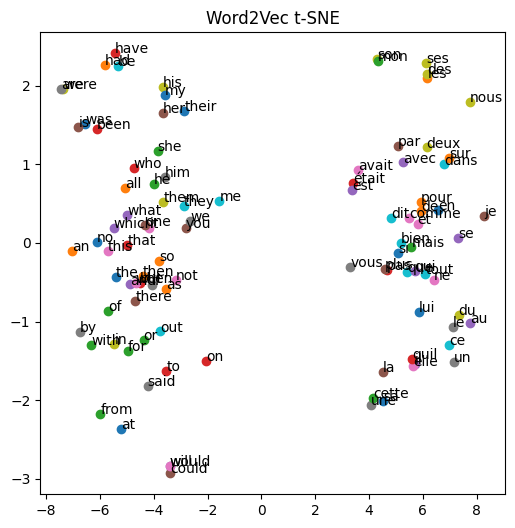

In [49]:
def visualize_embeddings(vectors, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(6, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]))

    plt.title(title)
    plt.show()
# Choose more words if available
sample_words = list(w2v_model.wv.index_to_key)[:100]
sample_vectors = np.array([w2v_model.wv[w] for w in sample_words])

# Adaptive perplexity
perplexity = min(30, len(sample_words) - 1)

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=42
)

tsne_vectors = tsne.fit_transform(sample_vectors)

visualize_embeddings(tsne_vectors, sample_words, "Word2Vec t-SNE")



## 6. Downstream Classification Task

In [30]:
y = df["lang"]

def train_classifier(X, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print(f"\n=== Results using {name} ===")
    print(classification_report(y_test, preds))

train_classifier(X_onehot, "One-hot")
train_classifier(X_tfidf, "TF-IDF")
train_classifier(X_w2v, "Word2Vec")
train_classifier(X_fasttext, "FastText")



=== Results using One-hot ===
              precision    recall  f1-score   support

          en       0.94      0.93      0.93     37929
          fr       0.93      0.94      0.93     38322

    accuracy                           0.93     76251
   macro avg       0.93      0.93      0.93     76251
weighted avg       0.93      0.93      0.93     76251


=== Results using TF-IDF ===
              precision    recall  f1-score   support

          en       0.94      0.94      0.94     37929
          fr       0.94      0.94      0.94     38322

    accuracy                           0.94     76251
   macro avg       0.94      0.94      0.94     76251
weighted avg       0.94      0.94      0.94     76251


=== Results using Word2Vec ===
              precision    recall  f1-score   support

          en       0.93      0.92      0.92     37929
          fr       0.92      0.93      0.92     38322

    accuracy                           0.92     76251
   macro avg       0.92      0.92  

In [46]:
print(w2v_model.wv.similarity("finance", "banque"))
print(w2v_model.wv.similarity("bank", "river"))
print(w2v_model.wv.similarity("finance", "river"))


0.60806185
0.8472782
0.37983036


In [51]:
w2v_model.wv.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=10
)

[('duke', 0.856959342956543),
 ('queen', 0.8015987277030945),
 ('bishop', 0.7829864025115967),
 ('abbe', 0.7704082727432251),
 ('princess', 0.7698385119438171),
 ('governor', 0.7285580635070801),
 ('surgeon', 0.7262750267982483),
 ('mercer', 0.7257944941520691),
 ('minister', 0.7244299054145813),
 ('lady', 0.7241138219833374)]

In [50]:
w2v_model.wv.most_similar("bank", topn=10)

[('shore', 0.890108585357666),
 ('platform', 0.8798996210098267),
 ('road', 0.8736739158630371),
 ('bridge', 0.8698309063911438),
 ('path', 0.8686501383781433),
 ('pavement', 0.8627081513404846),
 ('moor', 0.8617575764656067),
 ('staircase', 0.8601736426353455),
 ('coast', 0.8562435507774353),
 ('edge', 0.8556546568870544)]